## Notebook to compute upper limits on the merger for eccentric binary systems. 
                                                                                           -- Rahul Dhurkunde
### Requirements
* Sensitive search volume as a function of eccentricity and chirp mass.
* Model predicted eccentric and chirp mass distribution of binary systems.  

In [1]:
import pycbc
import numpy as np
import matplotlib.pyplot as plt
import scipy
import h5py
from pycbc import conversions
from scipy.stats import loguniform, gaussian_kde
from scipy.interpolate import interp1d, interp2d, RegularGridInterpolator, LinearNDInterpolator
from scipy.integrate import trapz, cumtrapz, quad
from random import choices
from collections import Counter
import seaborn as sns
import matplotlib as mpl
from matplotlib import rc
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from decimal import Decimal
from astropy import cosmology

sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

mpl.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 18

rc('font', family='serif', weight = 'bold')
rc('text', usetex=True)

colors = sns.color_palette("husl", 8)

In [28]:
model = 'fragione'

if model == 'belzynscki':
    ecc_10_file = 'pop-dist/bns/belzynski/ecc_10.hdf'
    mchirp_file = 'pop-dist/bns/belzynski/mchirp.hdf'
    BNS = True
    
    
elif model == 'sedda':
    ecc_10_file = 'pop-dist/nsbh/1.Sedda/ecc_10.hdf'
    mchirp_file = 'pop-dist/nsbh/1.Sedda/mchirp.hdf' 
    BNS = False
   
elif model == 'trani':
    ecc_10_file = 'pop-dist/nsbh/3.Trani/ecc_10.hdf'
    mchirp_file = 'pop-dist/nsbh/3.Trani/mchirp.hdf'
    BNS = False

elif model == 'fragione':
    ecc_10_file = 'pop-dist/nsbh/4.Fragionne/ecc_10.hdf'
    mchirp_file = 'pop-dist/nsbh/4.Fragionne/mchirp.hdf'
    BNS = False
    
else:
    raise ValueError("Check model name")
    
print("\n \t \t \t Computing for %s \n " %model)


 	 	 	 Computing for fragione 
 


### Functions to estimate the sensitive volume from the search results

In [29]:
def get_vol(obs_mchirp, obs_ecc, dist_mchirp, dist_ecc, mchirp_grid, ecc_grid):
    '''
    This function takes 1D arrays of sensitive volume as functions of eccentricity or mchirp, and 
    interpolates the sensitive volume over a new range of the two parameters.
    If the provided range is outside the search scope, then we extrapolate the values.

    Parameters
    ----------
    obs_mchirp : array_like
         array of mchirp values used in search analysis.
    obs_ecc : array_like
         array of eccentric values used in search analysis.
    dist_mchirp : array_like
         sensitive distance at the obs_mchirp values.
    dist_ecc : array_like
         sensitive distance at the obs_ecc values.
    mchirp_grid: array_like
         new grid of mchirp values for interpolation.
    ecc_grid: array_like
         new grid of eccentric values for interpolation.

    Returns
    -------
    newvol_mchirp: array_like
        volume at the mchirp_grid points.
    newvol_ecc: array_like
        volume at the ecc_grid points.
    mchirp_vol_interp: interpolant
        interpolant for volume as a function of mchirp.
    ecc_vol_interp: interpolant
        interpolant for volume as a function of ecc.
    '''
    vol_mchirp = 4/3*np.pi*np.power(dist_mchirp,3)
    vol_ecc = dist_ecc
    
    #Get 1d interpolants
    mchirp_vol_interp = interp1d(obs_mchirp, vol_mchirp, fill_value='extrapolate', kind='cubic')
    ecc_vol_interp = interp1d(obs_ecc, vol_ecc, fill_value='extrapolate')
    
    newvol_mchirp = mchirp_vol_interp(mchirp_grid)
    newvol_ecc = ecc_vol_interp(ecc_grid)/np.trapz(ecc_vol_interp(ecc_grid), ecc_grid)    
    return newvol_mchirp, newvol_ecc, mchirp_vol_interp, ecc_vol_interp   

### Read the eccentricity samples from various pop models

Opening pop-dist/nsbh/4.Fragionne/ecc_10.hdf
Sources in the log(ecc) ranging from  [-2.996, -0.005] :  0.9823982398239822
Sources in the log(ecc) ranging from  [-2.0, -0.006] :  0.8626920007132053
Fraction of sources 87.815 % 26098 out of 29997


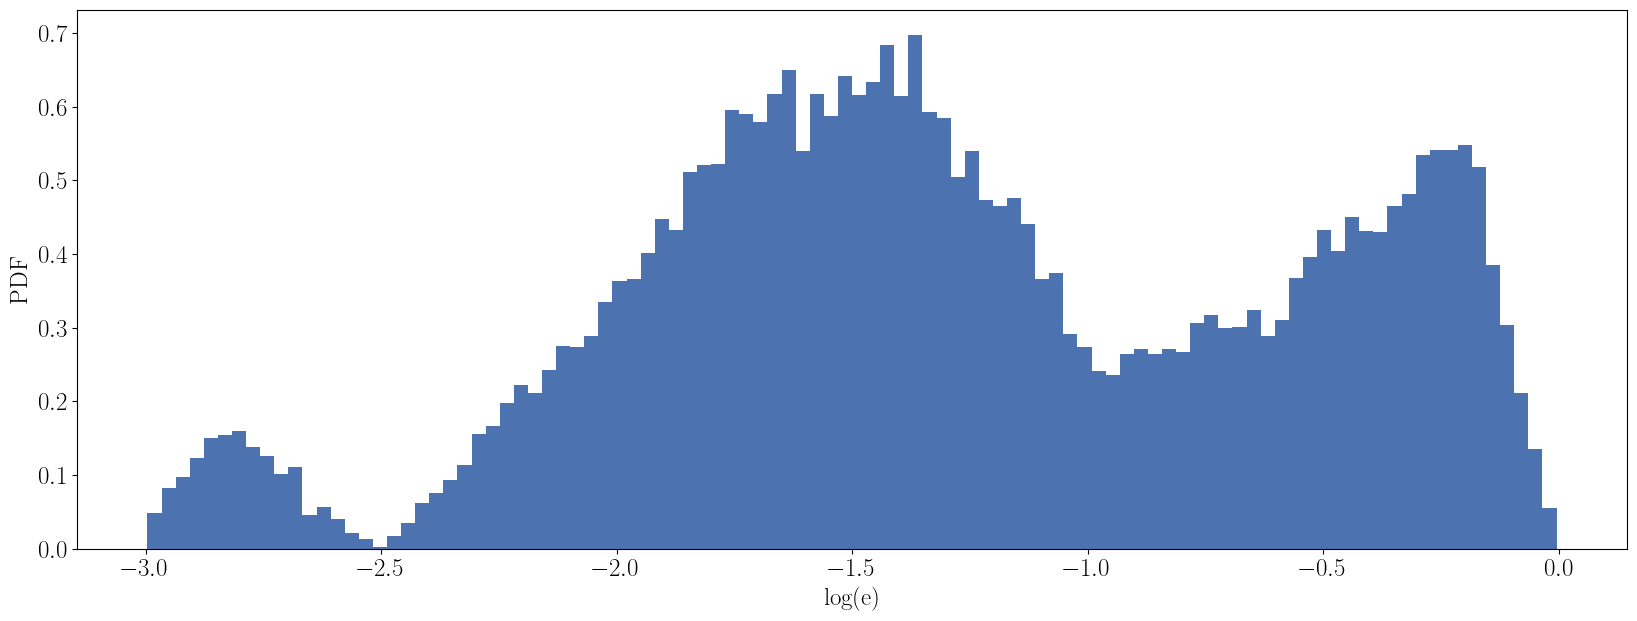

In [30]:
def read_ecc_samples(samples_file):
    ''' This functions extracts eccentricity samples, a grid of eccentricity values and the corresponding pdf values at the grid points 
    from a given .hdf file '''
    
    f = h5py.File(samples_file, 'r')
    print('Opening', samples_file)
    
    ecc_grid = f['ecc_grid'][:]
    pdf_values = f['pdf_values'][:]
    samples = f['samples'][:]
    f.close()
    return ecc_grid, pdf_values, samples

ecc_grid, pdf_values, ecc_samples = read_ecc_samples(ecc_10_file)
ecc_spacing = ecc_grid[1] - ecc_grid[0]
ecc_interp = interp1d(ecc_grid, pdf_values, fill_value='extrapolate', kind='linear')

# We can estimate the fraction of sources with detectable eccentricities e.g. 0.01
## Define a new grid with the exact spacing as the original grid but starting at a higher value e.g e in [0.01, 1]
elow = 1e-2
newecc_grid = np.arange(elow, max(ecc_grid), ecc_spacing)

# Estimating the number of sources (in \%) in our region of interest 
full_ecc = np.trapz(ecc_interp(ecc_grid), ecc_grid)
partial_ecc = np.trapz(ecc_interp(newecc_grid), newecc_grid)

print('Sources in the log(ecc) ranging from ', [round(np.log10(min(ecc_grid)),3), round(np.log10(max(ecc_grid)),3)], ': ', full_ecc)
print('Sources in the log(ecc) ranging from ', [round(np.log10(min(newecc_grid)),3), round(np.log10(max(newecc_grid)),3)], ': ', partial_ecc)
print('Fraction of sources', round(partial_ecc/full_ecc*100,3), '%', len(np.where(ecc_samples>1e-2)[0]), 'out of', len(ecc_samples))

## Plot the log(e) distribution

plt.hist(np.log10(ecc_samples), density=True, bins=100)
plt.xlabel('log(e)')
plt.ylabel('PDF')
plt.show()

### Similarly extract the mchirp samples

Sources in the mchirp ranging from:  [2.81, 7.32] 0.9997350000000002
Sources in the mchirp ranging from:  [2.81, 7.32] 0.9997349999999977
Mchirp fraction:  99.99999999999976 %
Total fraction of sources: 0.878149


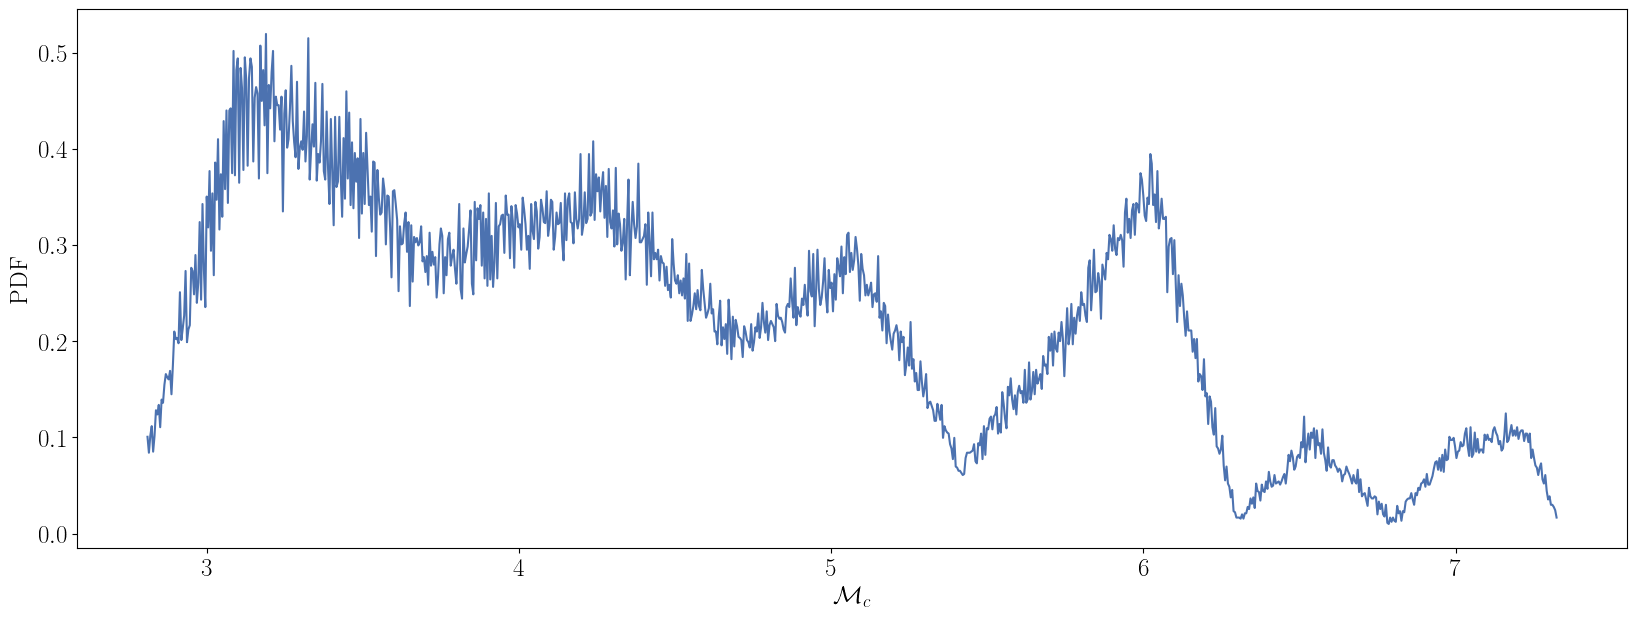

In [31]:
def read_mchirp_samples(samples_file):
    ''' This functions extracts mchirp samples, a grid of mchirp values and the corresponding pdf values at the grid points 
    from a given .hdf file '''
    f = h5py.File(samples_file, 'r')
    mchirp_grid = f['mchirp_grid'][:]   
    pdf_values = f['pdf_values'][:]
    samples = f['samples'][:]
    return mchirp_grid, pdf_values, samples

mchirp_grid, pdf_values, mchirp_samples = read_mchirp_samples(mchirp_file)
mchirp_spacing = mchirp_grid[1] - mchirp_grid[0]
mchirp_interp = interp1d(mchirp_grid, pdf_values, fill_value='extrapolate')

## Setting the lower limit (mc_min) according the model 
if bool(BNS):
    mc_min = 1.0
else:
    if min(mchirp_grid) > 1.92:
        mc_min = min(mchirp_grid)
    else:
        mc_min = 1.92
#Use the lower limit to define a new grid with the original spacing
newmchirp_grid = np.arange(mc_min, max(mchirp_grid), mchirp_spacing)

# Estimating the number of sources (in \%) in our region of interest 
full_mchirp = np.trapz(mchirp_interp(mchirp_grid), mchirp_grid)
partial_mchirp = np.trapz(mchirp_interp(newmchirp_grid), newmchirp_grid)

print('Sources in the mchirp ranging from: ', [round(min(mchirp_grid),2), round(max(mchirp_grid),2)], full_mchirp)
print('Sources in the mchirp ranging from: ', [round(min(newmchirp_grid),2), round(max(newmchirp_grid),2)], partial_mchirp)
print('Mchirp fraction: ',  partial_mchirp/full_mchirp*100, '%')

print('Total fraction of sources:', round(partial_mchirp*partial_ecc/full_mchirp/full_ecc, 6))

# Plot the mchirp distribution

plt.plot(mchirp_grid, mchirp_interp(mchirp_grid))
plt.xlabel("$\mathcal{M}_{c}$")
plt.ylabel('PDF')
plt.show()

### Load the search sensitivity as a function of mchirp and eccentricity

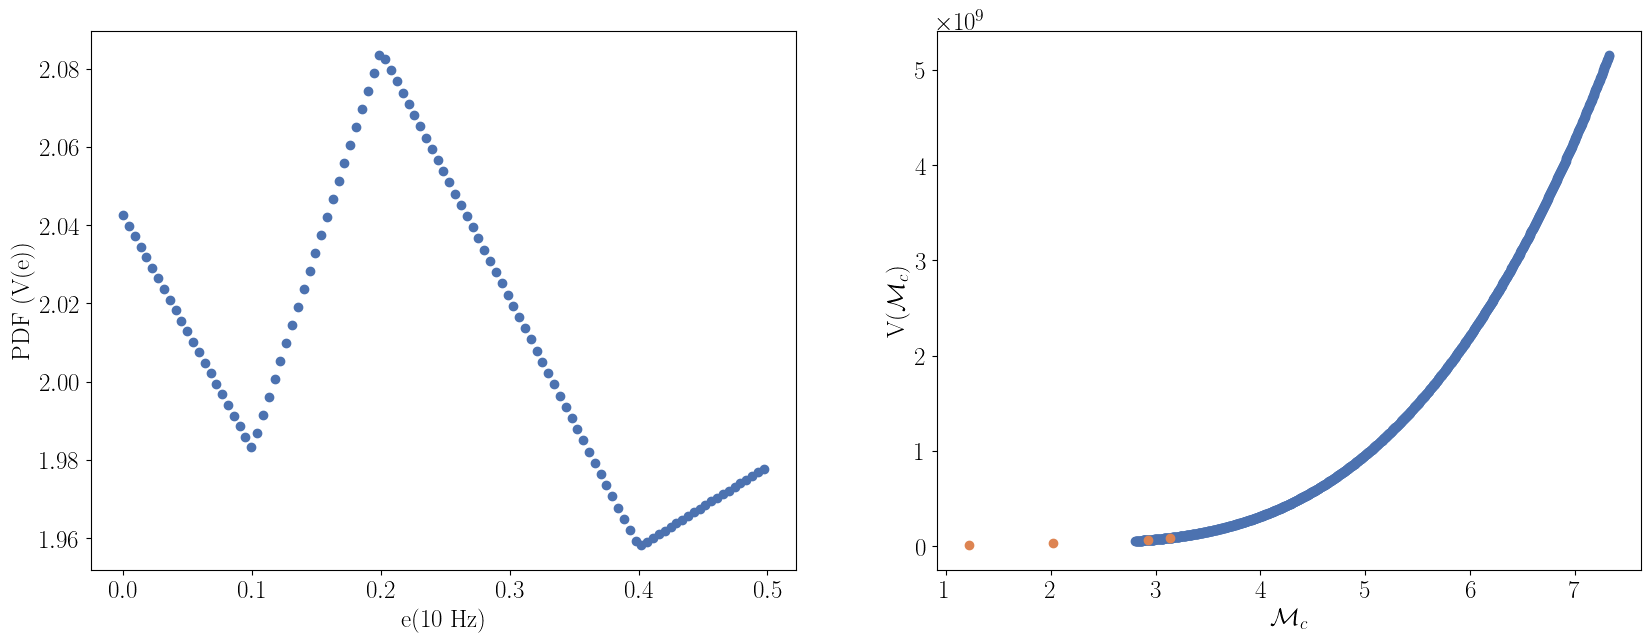

In [32]:
## Load the sensitive volume only as a function of mchirp
f = h5py.File('sens_distance/fixed-ecc-0.0.hdf')  
obs_mchirp = []
dist_mchirp = []
for x in f['data'].keys():
    obs_mchirp.append(float(x))
    dist_mchirp.append(f['data/%s'%x][:][0])
    
## Load the sensitive volume only as a function of eccentricity
g = h5py.File('sens_distance/fixed-mchirp-2.01903774.hdf')
obs_ecc = []
dist_ecc = []
for x in g['data'].keys():
    obs_ecc.append(float(x))
    dist_ecc.append(g['data/%s'%x][:][0])

obs_ecc = np.array(obs_ecc)*2    #Converting the eccentricities to 10 Hz. Assuming the e_10 is twice e_20.

# Total search observation time in years
obs_time = 0.682 

#Define parameter grids to interpolate the sensitive volume. The parameter ranges should be according to the injections performed.
only_vol_mchirp_grid = np.arange(0.9, 4.35, mchirp_spacing)
only_vol_ecc_grid = np.arange(1e-8, 0.5, mchirp_spacing)
vol_mchirp, vol_ecc, mchirp_vol_interp, ecc_vol_interp = get_vol(obs_mchirp, obs_ecc, dist_mchirp, dist_ecc, only_vol_mchirp_grid, only_vol_ecc_grid)
eccvol_norm = np.trapz(ecc_vol_interp(only_vol_ecc_grid), only_vol_ecc_grid)



fig1, ax1 = plt.subplots(1,2)
ax1[0].scatter(only_vol_ecc_grid, ecc_vol_interp(only_vol_ecc_grid)/np.trapz(ecc_vol_interp(only_vol_ecc_grid), only_vol_ecc_grid))
ax1[0].set_xlabel('e(10 Hz)')
ax1[0].set_ylabel('PDF (V(e))')

ax1[1].scatter(mchirp_grid, mchirp_vol_interp(mchirp_grid))
ax1[1].scatter(obs_mchirp, 4/3*np.pi*np.power(dist_mchirp,3))
ax1[1].set_xlabel('$\mathcal{M}_c$')
ax1[1].set_ylabel('V($\mathcal{M}_c$)')
plt.show()

### We can also establish upper limits for future detector configuration assuming a linear scaling for the sensitive distance
##### We obtain the scale factor by taking the ratio of inspiral ranges computed using an estimated analytical PSD of the future detectors vs the O3 PSD. The scale factors obtained:
* O3 PSD: 1
* A+: 3
* A#: 5.78

In [33]:
dist_factor = 1
dist_mchirp_enhanced = np.array(dist_mchirp) * dist_factor
vol_mchirp_enhanced, vol_ecc, enh_mchirp_vol_interp, enh_ecc_vol_interp = get_vol(obs_mchirp, obs_ecc, dist_mchirp_enhanced, dist_ecc, only_vol_mchirp_grid, only_vol_ecc_grid)

print(" \n Computing using dist factor: ", dist_factor)

 
 Computing using dist factor:  1


### Now we compute the 90% confidence upper limit on the merger rate
#### In essence we have to compute the integral:
$$ V = \dfrac{\int V(\mathcal{M}_c) p(\mathcal{M}_c) d\mathcal{M}_c \int V(e) p(e) de}{\int p(e)de \int{p(\mathcal{M}_c) d\mathcal{M}_c} \int V(e)de} $$
#### and the 90% upper limit for an obs time $T$ is given by:
$$ R_{90} = \dfrac{2.303}{VT} $$

In [34]:
#Define new (generally smaller) grids according to the search regions
partialmchirp_grid = np.arange(mc_min, max(mchirp_grid), mchirp_spacing)
partialecc_grid = np.arange(elow, max(ecc_grid), ecc_spacing)

partial_ecc_int = np.trapz(ecc_vol_interp(partialecc_grid)*ecc_interp(partialecc_grid), partialecc_grid) \
                                / np.trapz(ecc_interp(partialecc_grid), partialecc_grid) / eccvol_norm
partial_mchirp_int = np.trapz(enh_mchirp_vol_interp(partialmchirp_grid)*mchirp_interp(partialmchirp_grid), partialmchirp_grid) \
                            / np.trapz(mchirp_interp(partialmchirp_grid), partialmchirp_grid) 
partial_int = partial_mchirp_int*obs_time/10**9*partial_ecc_int


print('Model: \t', model, 'dist factor: ', dist_factor)
print('Mchirp integrals')
print('\t mchirp in: ', [round(min(partialmchirp_grid),2), round(max(partialmchirp_grid),2)], '\t', partial_mchirp_int)

print('Ecc integrals')
print('\t loge in', [round(np.log10(min(partialecc_grid)),3), round(np.log10(max(partialecc_grid)),3)], '\t', partial_ecc_int)

print('Upper limit: ', round(2.303/partial_int,4), 'GPc^(-3) Yr^(-1)')

Model: 	 fragione dist factor:  1
Mchirp integrals
	 mchirp in:  [2.81, 7.32] 	 936137222.2274343
Ecc integrals
	 loge in [-2.0, -0.006] 	 1.9881741655966738
Upper limit:  1.8143 GPc^(-3) Yr^(-1)


### Table of predicted local merger rates and the estimated fraction of sources with e > 0.01 

In [16]:
predicted_rate_list = {'Belczynski et al. (2018a) (globular cluster)': np.array([0.02,0.5,0.05]),
                'Arca Sedda (2020b) (globular cluster)': np.array([0.1]),
                'Trani et al. (2021) (triples)': np.array([0.04, 0.34, 0.11]),
                'Fragione et al. (2019) (nuclear cluster)': np.array([0.06, 0.1])
                      }

fraction_sources = {'Belczynski et al. (2018a) (globular cluster)': 0.000761,
                'Arca Sedda (2020b) (globular cluster)': 0.049,
                'Trani et al. (2021) (triples)': 0.013,
                'Fragione et al. (2019) (nuclear cluster)': 0.063
                      }

### Estimated upper limits for current observations and scaled appropriately for a network of A+ and A# detectors

In [35]:
ecc_upper_limit_based_on_obs = {'Belczynski et al. (2018a) (globular cluster)': 104.91,
                'Arca Sedda (2020b) (globular cluster)': 8.426,
                'Trani et al. (2021) (triples)': 1.235,
                'Fragione et al. (2019) (nuclear cluster)': 1.814
                        }

ecc_upper_limit_aplus = {'Belczynski et al. (2018a) (globular cluster)': 3.88,
                'Arca Sedda (2020b) (globular cluster)': 0.312,
                'Trani et al. (2021) (triples)': 0.042,
                'Fragione et al. (2019) (nuclear cluster)': 0.073
                        }

ecc_upper_limit_asharp = {'Belczynski et al. (2018a) (globular cluster)': 0.543,
                'Arca Sedda (2020b) (globular cluster)': 0.044,
                'Trani et al. (2021) (triples)': 0.0058,
                'Fragione et al. (2019) (nuclear cluster)': 0.0103
                        }

### We also establish the upper limits for a network of third generation detectors.
First we simulate a population of source using the model predicted distributions ($m_1, m_2, e$) and assuming a local merger rate of 0.1 Gpc^(-3) Yr^(-1) distributed up to a redshift of z=10. These sources are assigned uniformly random orientation and inclination angles. Then using a network of future detectors, we estimate the fraction $ \epsilon = \dfrac{N_{found}}{N_{total}}$ of sources that will have an optimal snr > 10.0. <br>
The 90% upper limit in terms of $\epsilon$ is given by
$$ R_{90} = \dfrac{2.303}{V_c T \epsilon }, $$
where $V_c$ is the total comoving volume up to the redshift 10.
Below we provide the fraction of sources obtained for the following detector networks:
* three A# 
* Einstein telescope
* Cosmic explorer (40 km), cosmic explorer (20 km), ET (single arm)

In [23]:
sens_asharp = [0.001, 0.007, 0.01, 0.011]
sens_et = [0.04, 0.28, 0.47, 0.42]
sens_ce_ce_et = [0.25,0.66,0.74,0.76]

total_volume = cosmology.Planck15.comoving_volume(10).value/10**9
print('Total_volume:', total_volume, 'Gpc^3')

for item in sens_et:
    print('Rate: %.2E'  %Decimal(2.303/total_volume/obs_time/item))

Total_volume: 3763.143105730441 Gpc^3
Rate: 2.24E-02
Rate: 3.20E-03
Rate: 1.91E-03
Rate: 2.14E-03


#### we obtain the upper limits for next-gen detectors as shown below 

In [25]:
ecc_upper_limit_asharp = {'Belczynski et al. (2018a) (globular cluster)': 6.12E-01,
                'Arca Sedda (2020b) (globular cluster)': 8.74E-02,
                'Trani et al. (2021) (triples)': 6.12E-02,
                'Fragione et al. (2019) (nuclear cluster)': 5.56E-02
                        }

ecc_upper_limit_et_only = {'Belczynski et al. (2018a) (globular cluster)': 1.53E-02,
                'Arca Sedda (2020b) (globular cluster)': 2.19E-03,
                'Trani et al. (2021) (triples)': 1.30E-03,
                'Fragione et al. (2019) (nuclear cluster)': 1.46E-03
                          }

ecc_upper_limit_ce_ce_et = {'Belczynski et al. (2018a) (globular cluster)': 2.45E-03,
                'Arca Sedda (2020b) (globular cluster)': 9.27E-04,
                'Trani et al. (2021) (triples)': 8.27E-04,
                'Fragione et al. (2019) (nuclear cluster)': 8.05E-04
                        }

### Plot the estimated upper limits for the different detector configurations along with the modelled predicted merger rates.

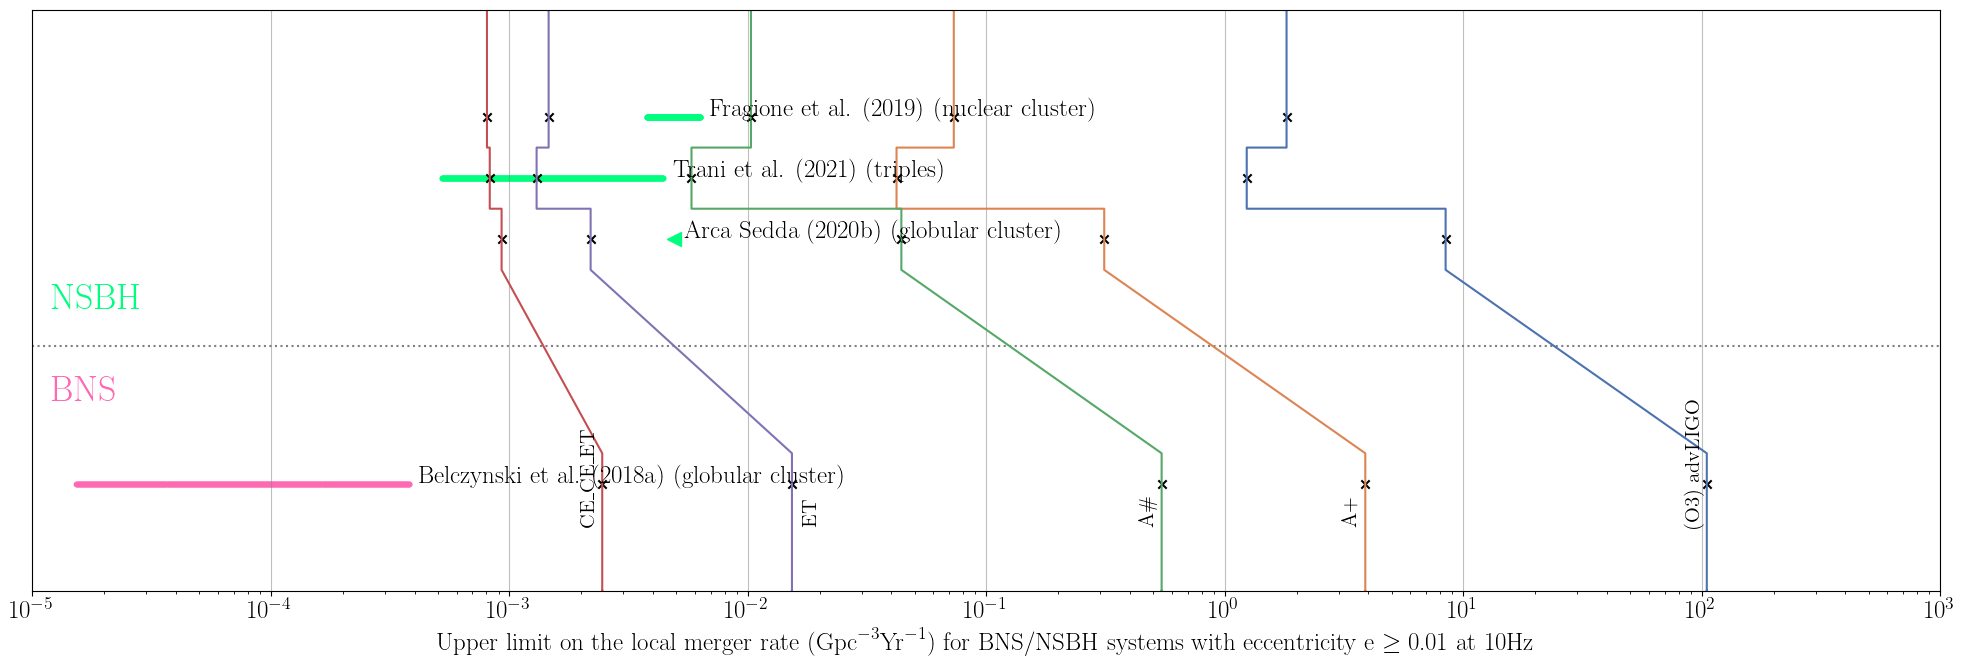

In [36]:
fig, axs = plt.subplots()
colors = ['hotpink', 'springgreen']

xmin = 1e-5
xmax = 1e3
ymax = 38

count = 2
diff_mult = 4
key_index = 0
k = 0
time_req = []
limit_array = []
for key in predicted_rate_list.keys():
    #print(count, key)
    #Current detectors fractional_rate
    fractional_rate = np.array(predicted_rate_list[key])*fraction_sources[key]
    
    #Time required by future-gen detect 
    extra_vdist = 1
    size = 10

    if len(fractional_rate) > 1:
        rate = np.logspace(np.log10(min(fractional_rate)), np.log10(max(fractional_rate)), 500)
        axs.scatter(rate, np.full(len(rate), 4*count - extra_vdist), s=size, color=colors[k], label=key)
        
        #Our upper limit
        upper_limit = ecc_upper_limit_based_on_obs[key]
        limit_array.append(upper_limit)
        
        #axs.axvline(upper_limit, color='tomato')
        #axs.text(upper_limit+0.2, 24, key, rotation=90, fontsize='small')
        
        if key != 'Hamers and Thompson (2019) (triples)':
            axs.text(max(fractional_rate)*1.1, diff_mult*count - 0.5, key, verticalalignment='center', fontsize='medium', zorder=6)
        else:
            axs.text(min(fractional_rate)*0.4, diff_mult*(count-1) + 0.5, key, verticalalignment='center', fontsize='medium', zorder=6)           
    else:
        axs.text(fractional_rate*1.1, diff_mult*count-0.5, key, verticalalignment='center', fontsize='medium')
        axs.scatter(fractional_rate, diff_mult*count - extra_vdist, marker='<', s=100, color=colors[k], label=key)
        
    if key_index == 0:
        count += 2
        plt.axhline(4*count, linestyle='dotted',color='gray')
        axs.text(1.2*xmin, diff_mult*count-3, 'BNS', fontsize='x-large', horizontalalignment='left', verticalalignment='center', color=colors[k])
        k += 1
        axs.text(1.2*xmin, diff_mult*count+3, 'NSBH', fontsize='x-large', horizontalalignment='left', verticalalignment='center', color=colors[k])
        count += 1
        
    count += 1 
    key_index += 1

    
# Req time lines
time_req_det = []
limits_det = []
hatch_list = ['x', 'o', '.', '--']
det_list = ['(O3) advLIGO', 'A+', 'A\#', 'CE_CE_ET', 'ET']

k=0
for det in det_list:
    time_req = np.array([])
    limit_array = []
    
    if det == '(O3) advLIGO':
        ul_array = ecc_upper_limit_based_on_obs
    elif det == 'A+':
        ul_array = ecc_upper_limit_aplus
    elif det == 'A\#':
        ul_array = ecc_upper_limit_asharp
    elif det == 'CE2+CE2+A\#':
        ul_array = ecc_upper_limit_ce_ce_asharp
    elif det == 'ET':
        ul_array = ecc_upper_limit_et_only
    elif det == 'CE_CE_ET':
        ul_array = ecc_upper_limit_ce_ce_et
    
    count = 2
    key_index = 0
    y_values = []
    for key in predicted_rate_list.keys():
        upper_limit = ul_array[key]
        #print(key, upper_limit)
        
        if key_index == 0:
            y_values.append(0)
            limit_array.append(upper_limit)
        
        #Transition form BNS to NSBH
        if key_index == 0:
            y_values.append(diff_mult*(count-4) - extra_vdist + diff_mult/2 )
            limit_array.append(upper_limit)
            if det == 'ET':
                axs.text(limit_array[-1]*1.1, 2.2*count, det, fontsize='small', rotation=90)
            else:
                axs.text(limit_array[-1]*0.8, 2.2*count, det, fontsize='small', rotation=90)
        
        #lower edge of the box
        y_values.append(diff_mult*count - extra_vdist - diff_mult/2)
        limit_array.append(upper_limit)
        
        #Og limit 
        y_values.append(diff_mult*count - extra_vdist)
        limit_array.append(upper_limit)
        axs.scatter(upper_limit, diff_mult*count - extra_vdist, marker='x', color='black')
        
        #Upper edge of the box
        y_values.append(diff_mult*count - extra_vdist + diff_mult/2)
        limit_array.append(upper_limit)
        
        if key_index == 3:
            y_values.append(ymax)
            limit_array.append(upper_limit)
        
        if key_index == 0:
            count += 3

        #Time required 
        obs_time = 1
        time_req = np.concatenate([time_req, obs_time*upper_limit/fractional_rate*dist_factor**(-3) ])
        count += 1
        key_index += 1
        
    axs.plot(limit_array, y_values)
        
    time_req_det.append((min(time_req), max(time_req)))
    limits_det.append((max(limit_array), min(limit_array)))
    k +=1
    

axs.yaxis.set_visible(False)
locmaj = ticker.LogLocator(base=10, numticks=15)
major_tick_locations = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000]
axs.xaxis.set_major_locator(ticker.FixedLocator(major_tick_locations))
axs.xaxis.set_major_formatter(ticker.ScalarFormatter())


axs.set_xscale('log')
axs.set_xlabel('Upper limit on the local merger rate ($\mathrm{Gpc}^{-3} \mathrm{Yr}^{-1}$) for BNS/NSBH systems with eccentricity e $\ge$ 0.01 at 10Hz')

axs.set_ylim(0,ymax)
axs.set_xlim(xmin,xmax)
axs.xaxis.grid(alpha=0.5, color='grey')

plt.tight_layout()
plt.savefig('final_plots/expected_ranges.png', dpi=600)
plt.show()